# Hierarchical Risk Parity

The key idea of hierarchical risk parity is to use hierarchical clustering on the covariance matrix to be able to group assets with similar correlations together and reduce the number of degrees of freedom by only considering 'similar' assets as substitutes when constructing the portfolio.

## Imports & Settings

In [40]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
sns.set_style('whitegrid')
np.random.seed(42)

## Load Data

In [853]:
df = pd.read_csv('../SampleDataSet.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
descr = df.describe()
df = df.groupby(['DATE','RP_ENTITY_ID'], as_index=False).first()
###col with 100% NA
cols_to_drop = descr.columns[descr.loc['count',:]==0]
###delete these cols
df = df.loc[:, ~df.columns.isin(cols_to_drop)]
q = 0.9995
df = df.loc[ (df['T0_RETURN']<df['T0_RETURN'].quantile(q)) 
            & (df['T0_RETURN']>df['T0_RETURN'].quantile(1-q)) 
            & (df['T1_RETURN']<df['T1_RETURN'].quantile(q)) 
            & (df['T1_RETURN']>df['T1_RETURN'].quantile(1-q)) ]



nb_date_ceil = 6000
nb_date_floor = 1764 #7y track record



list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)
                                                &(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)

df_track_perf = df.loc[df['RP_ENTITY_ID'].isin(list_asset),:]
# df_track_perf.describe()

df_track_perf['T0_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T0_RETURN'].copy()) ##use log return
df_track_perf['T1_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df_track_perf = df_track_perf.loc[:, ~df_track_perf.columns.isin(cols_to_drop)]

<ipython-input-853-ba8cdbe1c453>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_track_perf['T0_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T0_RETURN'].copy()) ##use log return
<ipython-input-853-ba8cdbe1c453>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_track_perf['T1_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T1_RETURN'].copy()) ##use log return


In [854]:
len(list_asset)

40

In [855]:
# monthly_returns = monthly_returns.dropna(axis=1)
# monthly_returns.columns.names = ['Ticker']
# monthly_returns.info()

weekly_returns = df_track_perf.loc[:,['DATE', 'RP_ENTITY_ID', 'T0_RETURN_log']].pivot_table(index='DATE',columns='RP_ENTITY_ID',values='T0_RETURN_log')
# weekly_returns = weekly_returns.resample('D').sum().dropna(how='all')
weekly_returns = weekly_returns.loc[weekly_returns.index.year >= 2010,:]
weekly_returns = weekly_returns.dropna(how='all')
weekly_returns

RP_ENTITY_ID,0157B1,047E26,12DE76,17EDA5,1921DD,1A3E1B,1D3EEA,228D42,24CB56,25102A,...,B3CB74,C83B88,CFF97C,D54E62,D6489C,D8442A,D91D4E,E70531,E8846E,EEA6B3
DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-0.021267,0.047971,NaN,0.007071,0.004705,0.000909,NaN,-0.001014,0.052437,0.004746,...,0.004591,-0.004314,-0.013541,0.010399,-0.003394,-0.000879,0.002633,-0.002358,-0.004216,NaN
2010-01-05,0.000297,0.051996,-0.010109,-0.006101,-0.000425,0.008694,0.008063,-0.005294,0.032581,NaN,...,0.010412,-0.019342,-0.004722,0.001479,-0.006834,-0.003882,0.001997,-0.001700,0.021614,-0.017859
2010-01-06,-0.023084,NaN,-0.011276,-0.008090,-0.009904,0.016173,NaN,-0.010900,NaN,-0.005210,...,0.009445,-0.011943,-0.013715,-0.004588,-0.019395,-0.020825,-0.008219,0.003932,-0.003284,-0.005071
2010-01-07,NaN,-0.036008,-0.001524,-0.015766,0.044737,0.033656,0.051764,-0.016497,0.035741,-0.019524,...,-0.012098,0.014920,0.016039,-0.009843,-0.009342,-0.007907,-0.033971,-0.009212,0.029810,NaN
2010-01-08,NaN,NaN,0.001253,0.007094,0.017342,NaN,NaN,0.002781,0.013083,0.006423,...,-0.015019,-0.007016,-0.007891,-0.002283,0.008226,0.002599,-0.004054,-0.008090,-0.013404,-0.022812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-10,0.001958,0.016068,-0.005163,-0.008890,-0.001074,-0.000727,-0.004959,-0.006424,0.001148,0.004220,...,-0.013945,-0.003875,-0.004845,0.001569,0.008418,-0.007762,-0.006598,0.002838,-0.003180,-0.021948
2017-02-13,0.007587,-0.016880,0.011191,0.009625,0.007395,0.004152,0.003229,0.007874,0.007579,0.009935,...,0.005483,0.004098,-0.001446,0.004253,0.004002,0.005495,0.006185,0.002469,0.000524,-0.002362
2017-02-14,-0.003510,0.022428,0.007272,0.000295,0.004642,0.015487,0.021373,0.000372,0.018698,-0.002208,...,0.005542,0.001681,-0.000254,-0.006077,NaN,0.009596,-0.013101,-0.005521,0.012354,-0.005568


## HRP Source

The first step is to compute a distance matrix that represents proximity for correlated assets and meets distance metric requirements. The resulting matrix becomes an input to the scipy hierarchical clustering function that computes the successive clusters using one of several available methods as discussed above.

In [856]:
def get_inverse_var_pf(cov, **kargs):
    """Compute the inverse-variance portfolio""" 
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

In [857]:
def get_distance_matrix(corr):
    """Compute distance matrix from correlation; 
        0 <= d[i,j] <= 1""" 
    return np.sqrt((1 - corr) / 2)

## Get Correlation Matrix

In [858]:
cov = weekly_returns.cov()
cov = cov.dropna(thresh=1, axis=1)
cov = cov.dropna(thresh=1, axis=0)
# cov = cov.T.dropna(how='all')
# cov = cov.T.dropna(how='all')

corr = weekly_returns.corr()
corr = corr.dropna(thresh=1, axis=1)
corr = corr.dropna(thresh=1, axis=0)
# corr = corr.T.dropna(how='all')
# corr = corr.T.dropna(how='all')

# corr.columns.names=['Ticker']

In [870]:
for col in cov.columns:
    if cov.loc[col,:].isna().sum()<0:
        print(col, cov.loc[col,:].isna().sum())

In [871]:
corr.fillna(0, inplace=True)
cov.fillna(0, inplace=True)


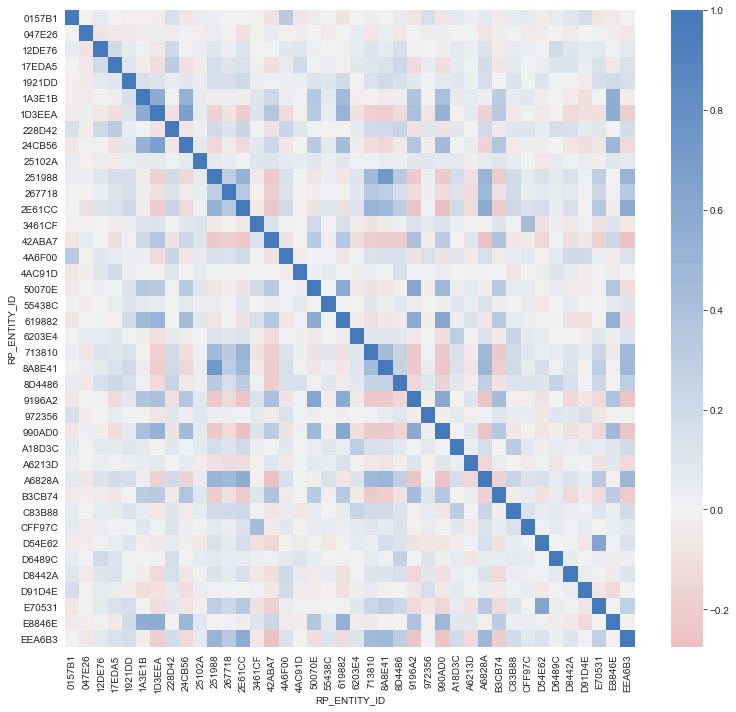

In [872]:
cmap = sns.diverging_palette(10, 250, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(corr, center = 0, cmap = cmap, ax=ax)
fig.tight_layout()


## Cluster Return Series

In [873]:
def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

In [874]:
# squareform(distance_matrix)
# distance_matrix.loc['1E1C4E','1E1C4E']#

In [875]:
distance_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(distance_matrix), 'single')
# linkage_matrix = linkage(distance_matrix, 'single')

In [876]:
sorted_idx = quasi_diagonalize(linkage_matrix)

### Plot Cluster Map

The linkage_matrix  can be used as input to the seaborn.clustermap function to visualize the resulting hierarchical clustering. The dendrogram displayed by seaborn shows how individual assets and clusters of assets merged based on their relative distances.

Compared to a seaborn.heatmap of the original correlation matrix above, there is now significantly more structure in the sorted data.

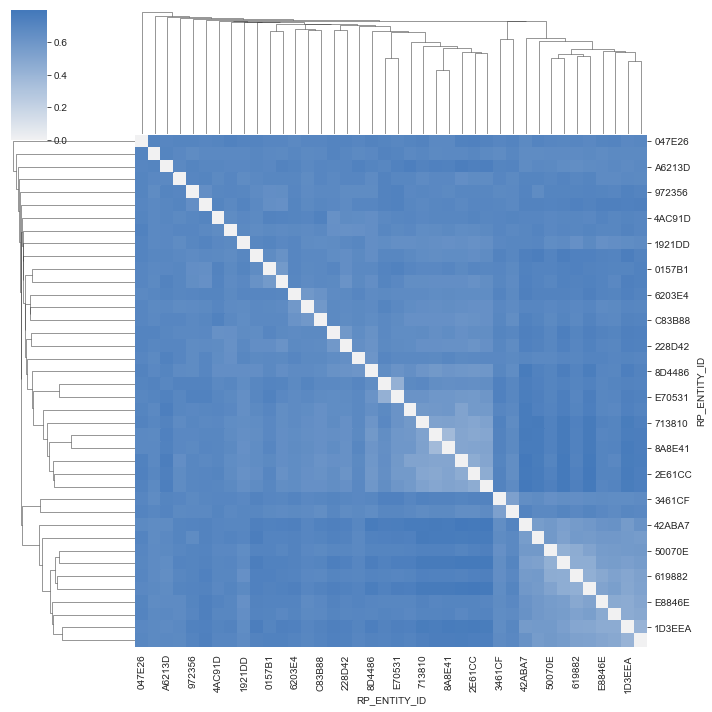

In [877]:
clustergrid = sns.clustermap(distance_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             cmap=cmap, center=0);

In [878]:
sorted_idx = clustergrid.dendrogram_row.reordered_ind

In [879]:
sorted_tickers = corr.index[sorted_idx].tolist()

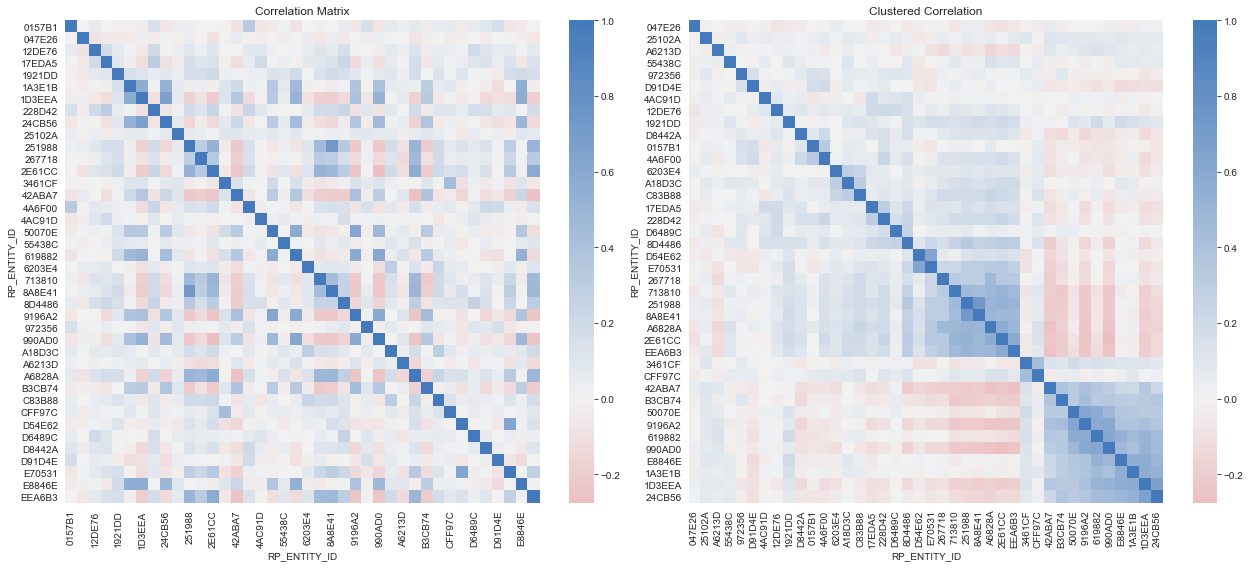

In [880]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(corr, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

In [887]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [888]:
# clustergrid = sns.clustermap(distance_matrix, 
#                              method='single', 
#                              row_linkage=linkage_matrix, 
#                              col_linkage=linkage_matrix, 
#                              cmap=cmap, center=0);

In [889]:
methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(distance_matrix)


<ipython-input-891-981a6b3e5043>:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method)


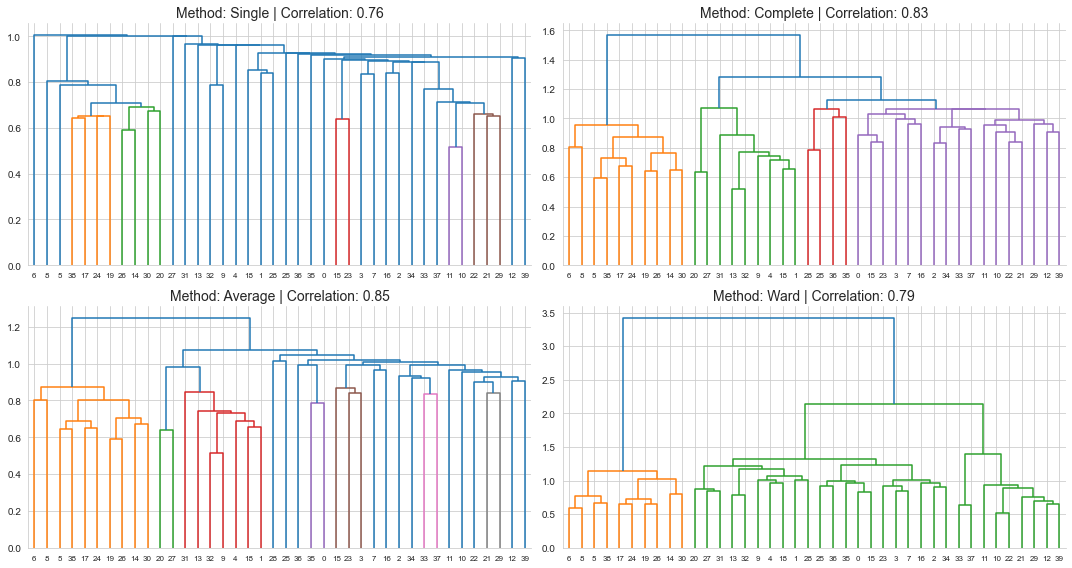

In [891]:
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    Z = linkage(distance_matrix, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z,
#                labels=data.label.values,
               orientation='top',
               leaf_rotation=0.,
               leaf_font_size=8.,
               ax=axes[i])
    axes[i].set_title(f'Method: {method.capitalize()} | Correlation: {c:.2f}',
                      fontsize=14)


sns.despine()
fig.tight_layout()

In [894]:
from sklearn.cluster import AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters=3)
clusters = clusterer.fit_predict(distance_matrix)

C:\Users\sdereynal\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [900]:
len(clusters)
clusters

array([2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 0, 0, 0, 2, 1, 2, 2, 1, 2, 1, 2, 0,
       0, 2, 1, 2, 1, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0], dtype=int64)

In [901]:
distance_matrix #Remplacer par le R2 ?

RP_ENTITY_ID,0157B1,047E26,12DE76,17EDA5,1921DD,1A3E1B,1D3EEA,228D42,24CB56,25102A,...,B3CB74,C83B88,CFF97C,D54E62,D6489C,D8442A,D91D4E,E70531,E8846E,EEA6B3
RP_ENTITY_ID,,,,,,,,,,,,,,,,,,,,,
0157B1,0.000000,0.705294,0.684871,0.706007,0.712720,0.713649,0.715287,0.652967,0.730483,0.692006,...,0.719641,0.687285,0.683080,0.718113,0.687591,0.672036,0.645574,0.730429,0.722108,0.704085
047E26,0.705294,0.000000,0.734022,0.723014,0.723034,0.722483,0.697474,0.717824,0.702043,0.714252,...,0.717585,0.708859,0.720941,0.717101,0.707324,0.722395,0.705830,0.700674,0.716505,0.726706
12DE76,0.684871,0.734022,0.000000,0.639681,0.680455,0.703617,0.727797,0.632478,0.709977,0.690578,...,0.719999,0.689261,0.692155,0.699357,0.636658,0.669171,0.687323,0.681086,0.702206,0.680360
17EDA5,0.706007,0.723014,0.639681,0.000000,0.673039,0.715436,0.742278,0.587767,0.740139,0.719441,...,0.731392,0.684052,0.700259,0.689827,0.666926,0.663506,0.692865,0.661219,0.726609,0.657462
1921DD,0.712720,0.723034,0.680455,0.673039,0.000000,0.650182,0.664297,0.688929,0.676814,0.691411,...,0.706803,0.663103,0.703092,0.665299,0.702426,0.703344,0.718367,0.647613,0.639560,0.647659
1A3E1B,0.713649,0.722483,0.703617,0.715436,0.650182,0.000000,0.461525,0.702014,0.485280,0.682994,...,0.586519,0.687025,0.674534,0.715915,0.708610,0.718938,0.742268,0.705934,0.472604,0.717419
1D3EEA,0.715287,0.697474,0.727797,0.742278,0.664297,0.461525,0.000000,0.738998,0.409839,0.684047,...,0.578796,0.724511,0.702222,0.724138,0.711572,0.754789,0.739118,0.745453,0.467243,0.771686
228D42,0.652967,0.717824,0.632478,0.587767,0.688929,0.702014,0.738998,0.000000,0.732659,0.699209,...,0.725282,0.668150,0.669350,0.684873,0.642955,0.651793,0.679279,0.673282,0.705524,0.640867
24CB56,0.730483,0.702043,0.709977,0.740139,0.676814,0.485280,0.409839,0.732659,0.000000,0.680067,...,0.562132,0.719654,0.697904,0.717360,0.706540,0.728728,0.743674,0.732581,0.502490,0.751863


## Compute Allocation

Using the tickers sorted according to the hierarchy induced by the clustering algorithm, HRP now proceeds to compute a top-down inverse-variance allocation that successively adjusts weights depending on the variance of the subclusters further down the tree. To this end, the algorithm uses bisectional search to allocate the variance of a cluster to its elements based on their relative riskiness.

In [830]:
def get_cluster_var(cov, cluster_items):
    """Compute variance per cluster"""
    cov_ = cov.loc[cluster_items, cluster_items]  # matrix slice
    w_ = get_inverse_var_pf(cov_)
    return (w_ @ cov_ @ w_).item()

In [831]:
def get_hrp_allocation(cov, tickers):
    """Compute top-down HRP weights"""

    weights = pd.Series(1, index=tickers)
    clusters = [tickers]  # initialize one cluster with all assets

    while len(clusters) > 0:
        # run bisectional search:
        clusters = [c[start:stop] for c in clusters
                    for start, stop in ((0, int(len(c) / 2)),
                                        (int(len(c) / 2), len(c)))
                    if len(c) > 1]
        for i in range(0, len(clusters), 2):  # parse in pairs
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            cluster0_var = get_cluster_var(cov, cluster0)
            cluster1_var = get_cluster_var(cov, cluster1)

            weight_scaler = 1 - cluster0_var / (cluster0_var + cluster1_var)
            weights[cluster0] *= weight_scaler
            weights[cluster1] *= 1 - weight_scaler
    return weights

In [832]:
hrp_allocation = get_hrp_allocation(cov, sorted_tickers)

## Visualize the result

The resulting portfolio allocation produces weights that sum to 1 and reflect the structure present in the correlation matrix.

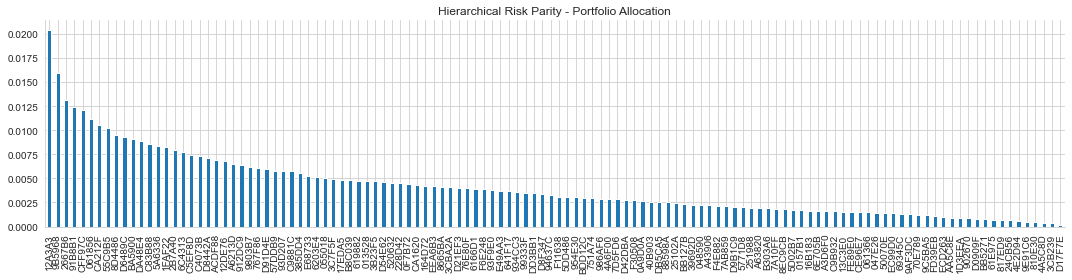

In [833]:
title = 'Hierarchical Risk Parity - Portfolio Allocation'
hrp_allocation.sort_values(ascending=False).iloc[::2].plot.bar(figsize=(15, 4),
                                                               title=title)
sns.despine()
plt.tight_layout()

How about a pie chart..

C:\Users\sdereynal\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


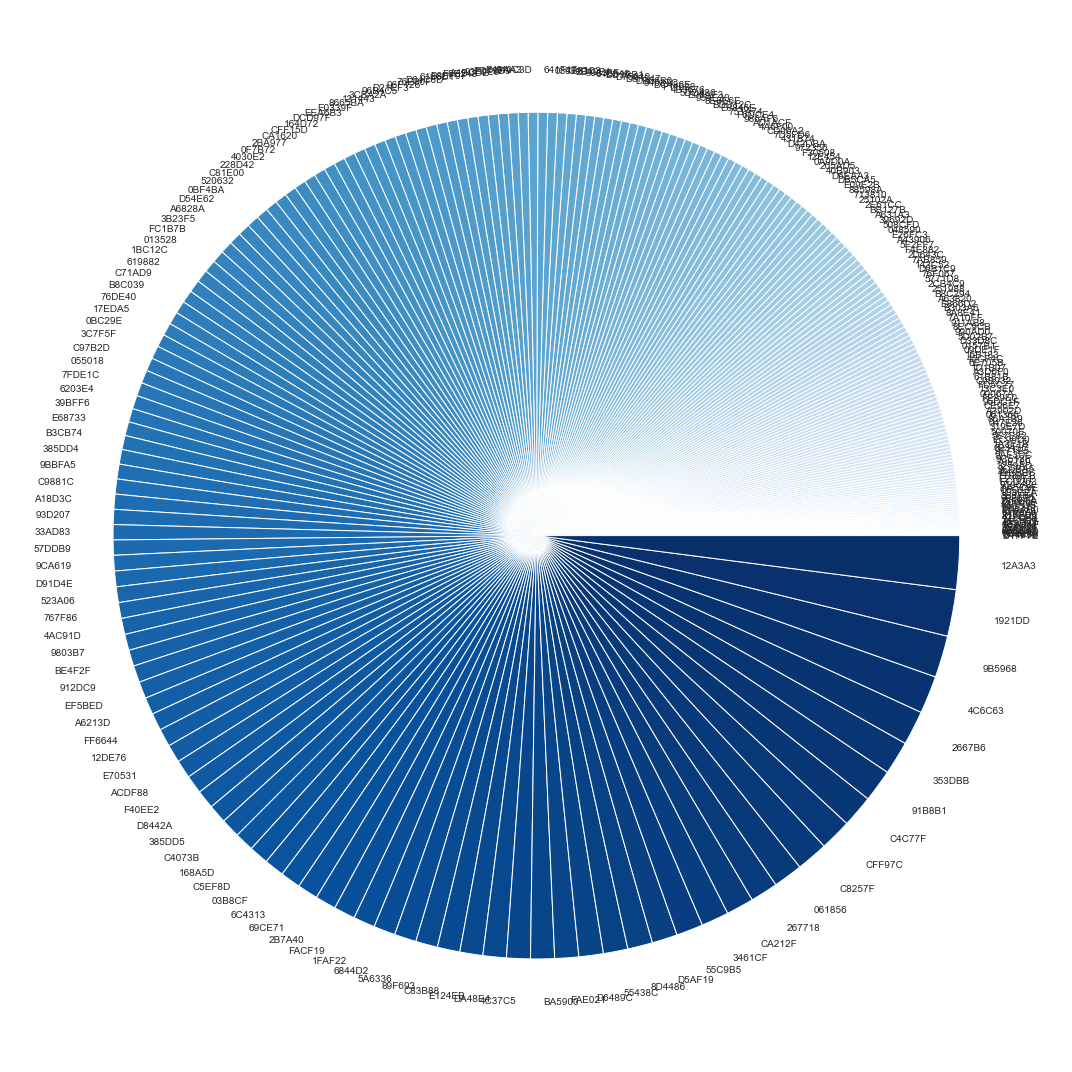

In [834]:
ax = hrp_allocation.sort_values().plot.pie(figsize=(15, 15), 
                                      cmap='Blues')
ax.set_ylabel('')
plt.tight_layout();